In [21]:
import matplotlib
import sys
sys.path.append('..')
from er_simulator.wc_model import WCTaskSim
from er_simulator.synaptic_weights_matrices import normalize, generate_synaptic_weights_matrices
from er_simulator.load_wc_params import load_wc_params
from er_simulator.boldIntegration import BWBoldModel
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import signal, stats, io

matplotlib.rcParams['font.family'] = 'Avenir'
matplotlib.rcParams['font.size'] = 16
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation of Resting State dynamics


### Matrix generation

In [22]:
num_regions = 30
num_modules = 3
X = 0.9
Z = 0.4
rest_factors = np.array([[X, 0.1, 0.1],
                                 [0.1, X, 0.1],
                                 [0.1, 0.1, X]])

c_rest = generate_synaptic_weights_matrices(num_regions,
                                            num_modules,
                                            factors=rest_factors,
                                            sigma=0.1)

D = np.ones((num_regions, num_regions)) * 250
np.fill_diagonal(D, 0)
norm_type = "cols"
Wij_rest = normalize(c_rest, norm_type=norm_type)


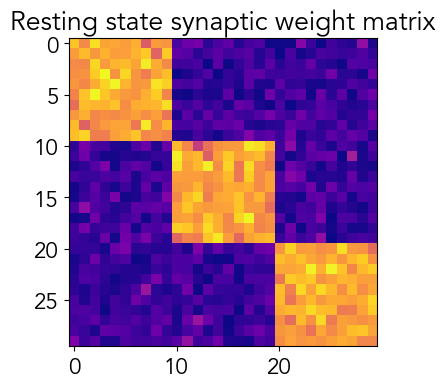

In [23]:
plt.figure( figsize = (10,4))
plt.imshow(Wij_rest); plt.title('Resting state synaptic weight matrix');


In [24]:
bw_params_random = {"normalize_constant": 2,
                    "fix": False,
                    "alpha": (0.32, 0.0015),
                    "rho":(0.34, 0.0024),
                    "tau":(0.98, 0.0568),
                    "gamma":(0.41, 0.002),
                    "k":(0.65, 0.015)
            }

wc_params = load_wc_params(config_file="../er_simulator/wc_params.yaml") 
wc_block = WCTaskSim(wc_params = wc_params,
                     bold_params=bw_params_random, 
                     C_rest=Wij_rest,
                     D=D,
                     output_type="syn_act",
                     TR=2,
                     rest_duration = 100,
                     fMRI_T=16,
                     rest_before=6,
                    )

CPU times: user 8.76 s, sys: 653 ms, total: 9.41 s
Wall time: 9.78 s


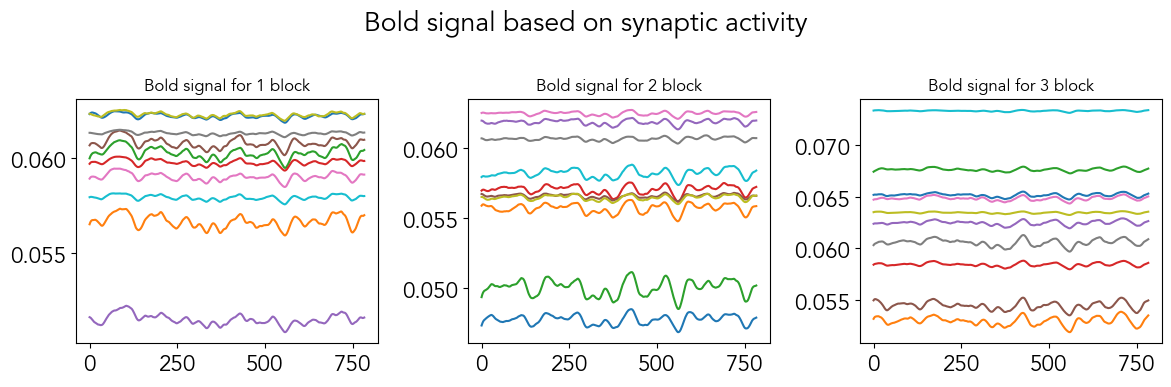

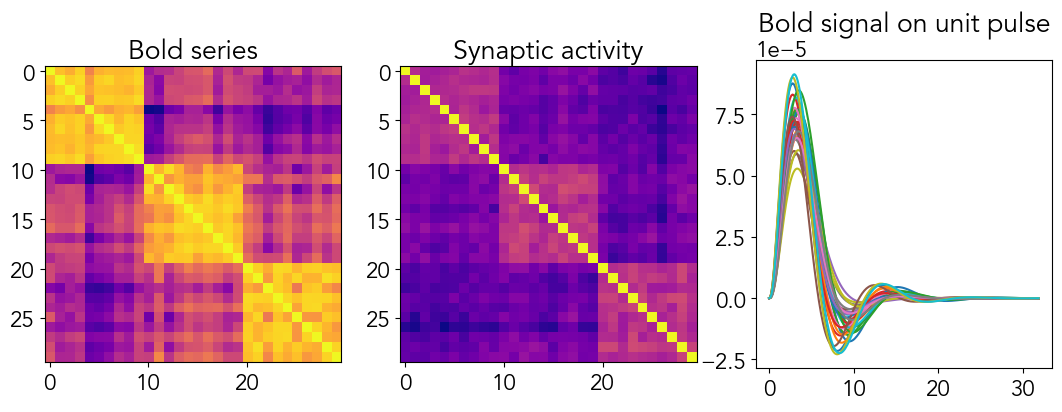

In [25]:
%%time
wc_block.generate_full_series(compute_bold=True)
tune = int(8/ wc_block.mTime)

fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.output['BOLD'][i*10:i*10+10,tune:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
plt.figure(figsize = (13,4))
tune = int(8/ wc_block.TR)
corr_series = np.corrcoef(wc_block.output['BOLD_TR'][:,tune:])
plt.subplot(131); plt.imshow(corr_series); plt.title("Bold series")
corr_series = np.corrcoef(wc_block.output['syn_act'])
plt.subplot(132); plt.imshow(corr_series); plt.title("Synaptic activity")
resampled_BOLD, time = wc_block.boldModel.run_on_impulse()
plt.subplot(133); plt.plot(time,resampled_BOLD.T); plt.title("Bold signal on unit pulse")
fig.tight_layout() 

In [26]:
bw_params_random = {"normalize_constant": 2,
                    "fix": True,
                    "alpha": (0.32, 0.0015),
                    "rho":(0.34, 0.0024),
                    "tau":(0.98, 0.0568),
                    "gamma":(0.41, 0.002),
                    "k":(0.65, 0.015)
            }

wc_params = load_wc_params(config_file="../er_simulator/wc_params.yaml") 
wc_block = WCTaskSim(wc_params = wc_params,
                     bold_params=bw_params_random, 
                     C_rest=Wij_rest,
                     D=D,
                     output_type="syn_act",
                     TR=2,
                     rest_duration = 100,
                     fMRI_T=400,
                     rest_before=6,
                    )

CPU times: user 8.16 s, sys: 623 ms, total: 8.79 s
Wall time: 8.6 s


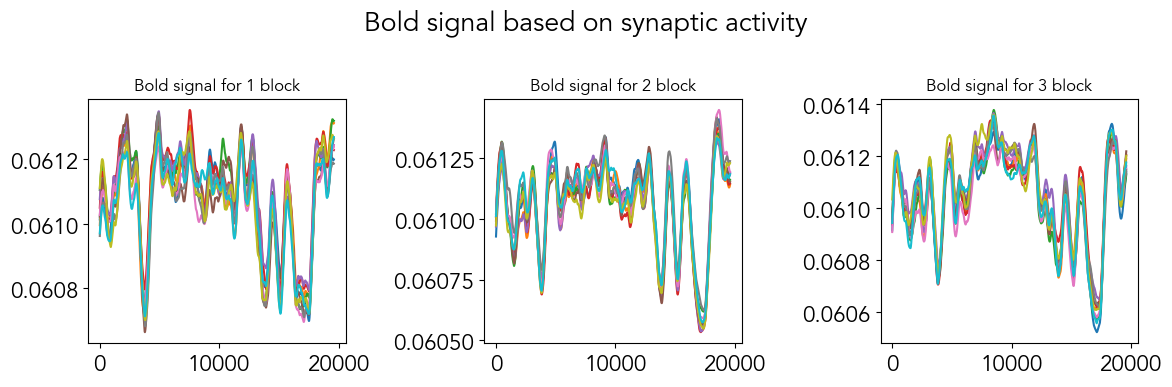

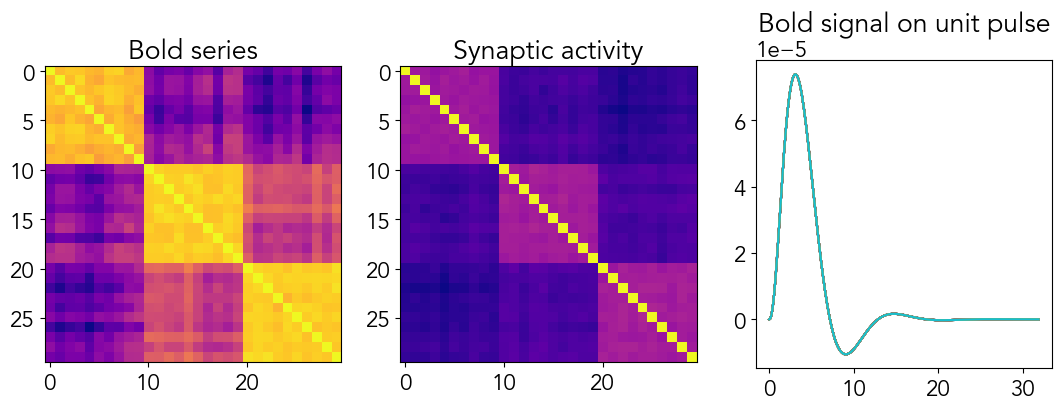

In [27]:
%%time
wc_block.generate_full_series(compute_bold=True)
tune = int(8/ wc_block.mTime)

fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.output['BOLD'][i*10:i*10+10,tune:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
plt.figure(figsize = (13,4))
tune = int(8/ wc_block.TR)
corr_series = np.corrcoef(wc_block.output['BOLD_TR'][:,tune:])
plt.subplot(131); plt.imshow(corr_series); plt.title("Bold series")
corr_series = np.corrcoef(wc_block.output['syn_act'])
plt.subplot(132); plt.imshow(corr_series); plt.title("Synaptic activity")
resampled_BOLD, time = wc_block.boldModel.run_on_impulse()
plt.subplot(133); plt.plot(time,resampled_BOLD.T); plt.title("Bold signal on unit pulse")
fig.tight_layout() 